In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

from two_rooms import *
from MFG_attractor import *
from Tri_Congestion_MFG import *
from Crowd_Avoidance_MFG import *

from utils import *

## **Imitation Learning in Mean Field Games**

Dans ce notebook, nous allons définir introduire plusieurs exemples de MFG

---

### *Population-Independant MFG : Toy Example*

A voir si on le fait mais pas très intéressant car se ramène à un single-agent problème. 

In [3]:
# ---------- Expérience ----------
env = TwoRoomsEnv(horizon=10)
demos = collect_expert_trajs(env, n_traj=500)
bc_policy = TabularPolicy()
train_bc(bc_policy, demos)

V_expert = 0.0                       # connu
V_bc     = evaluate(env, bc_policy)  # valeur imitée
gap      = V_expert - V_bc           # Nash imitation gap ici

print(f"Valeur BC : {V_bc:.2f}   |  Nash imitation gap : {gap:.2f}")

Valeur BC : 0.00   |  Nash imitation gap : 0.00


---

## **Population-Dependent MFG : Attractor MFG**

This toy model is designed to study how agents are progressively drawn toward a **negative absorbing state** $s_0$, through a probabilistic policy and nontrivial dynamics. It is one of the core models explored in the paper, and serves as a testbed for evaluating different policy learning strategies via imitation.

#### *Game Structure*

* States: $\mathcal{S} = {s_0, s_0}$

  * $s_0$: initial cost-free state
  * $s_0$: absorbing state with cost $r(s_0) = -1$

* Actions from $s_0$:

  * $a_0$: probabilistic action, with success rate depending on $\rho_t(s_0)$
  * $a_0$: direct action, guaranteed transition to $s_0$

#### *Transition Dynamics*

All agents start in state $s_0$, so:

$$
\rho_0(s_0) = 1,\quad \rho_0(s_1) = 0
$$

At each time step $t$, the proportion $\rho_t(s_0)$ evolves based on the applied policy:

* Test policy:

  $$
  \pi_\alpha(a_1 | s_0) = \alpha,\quad \pi_\alpha(a_0 | s_0) = 1 - \alpha
  $$

* Transition probabilities to $s_0$:

  * Under $a_0$: transition is guaranteed
  * Under $a_0$: transition occurs with probability $\min(1,; L \cdot \rho_t(s_0))$

#### Evolution of $\rho_t(s_0)$

Two variants of the dynamics are distinguished, depending on the applied policy:

* Dynamics under $\pi^{E\pi}$ (always choosing action $a_0$):

$$
\rho_{t+1}^{E\pi}(s_1) = \rho_t^{E\pi}(s_1) + (1 - \rho_t^{E\pi}(s_1)) \cdot \alpha
$$

which simplifies to:

$$
\rho_{t+1}^{E\pi} = \rho_t^{E\pi} + (1 - \rho_t^{E\pi}) \quad\text{with } \alpha = 1
$$

* Dynamics under $\pi_\alpha$:

$$
\rho_{t+1}^{\pi} = \rho_t^{\pi} + (1 - \rho_t^{\pi}) \cdot
\left[ \alpha + (1 - \alpha) \cdot \min(1, L \cdot \rho_t^{\pi}) \right]
$$

#### Computed Quantities

* **Behavior Cloning Error** (BC), constant:

$$
\varepsilon_t^\text{BC} = 2\alpha
$$

* **Vanilla-ADV Error**:

$$
\varepsilon_t^\text{vanilla} = 2 \cdot \left( \alpha + \rho_t^{E\pi}(1 - \alpha) \right)
$$

* **MPC-ADV Error**:

$$
\varepsilon_t^\text{MPC} = 2 \cdot \left( \alpha + \rho_t^{\pi}(1 - \alpha) \right)
$$

* **Nash Imitation Gap** (NIG):

$$
\mathcal{E}(\pi) = \sum_{t=0}^{H-1} \rho_t^{\pi}(s_1)
$$

#### Model Objective

This MFG is designed to analyze irreversible accumulation effects and dynamic amplification in response to a simple probabilistic policy. It highlights:

* the gap between a naive and an optimal policy,
* the ability of learning algorithms to approximate reference dynamics,
* the effect of nonlinear feedback in the transition dynamics, driven by $\min(1, L \cdot \rho_t(s_0))$.

It is particularly well-suited for testing **imitation learning algorithms in the MFG framework**, while preserving a fully analytical structure.


---

## Pareto Front: Trade-off Between Error and Performance in an MFG

The graph below represents a Pareto front that illustrates the fundamental trade-off between:

* Maximum MPC Error (`max ε_MPC`):
  measures the deviation between the agent's actual policy and a perfectly informed strategy (ideally reactive at every time step).
  A low error indicates a policy that is locally well-adapted to the dynamics.

* Nash Imitation Gap (`NIG`):
  a global performance indicator, corresponding to the sum of the proportions of agents reaching the target or congested states (such as $s_1$, $s_2$) throughout the time horizon.
  A high NIG reflects a policy that reaches its global objectives more effectively.

Each point in the scatter plot corresponds to a given policy (parameterized for example by $\alpha$ or $(\alpha_1, \alpha_2)$):

* Policies with low error but low NIG are conservative.
* Policies with high NIG but high error are aggressive or short-sighted.
* The Pareto front connects the strategies that cannot be improved on one objective without degrading the other.

This graph helps visualize efficient policies and supports selecting a meaningful trade-off between local dynamic consistency and global performance.


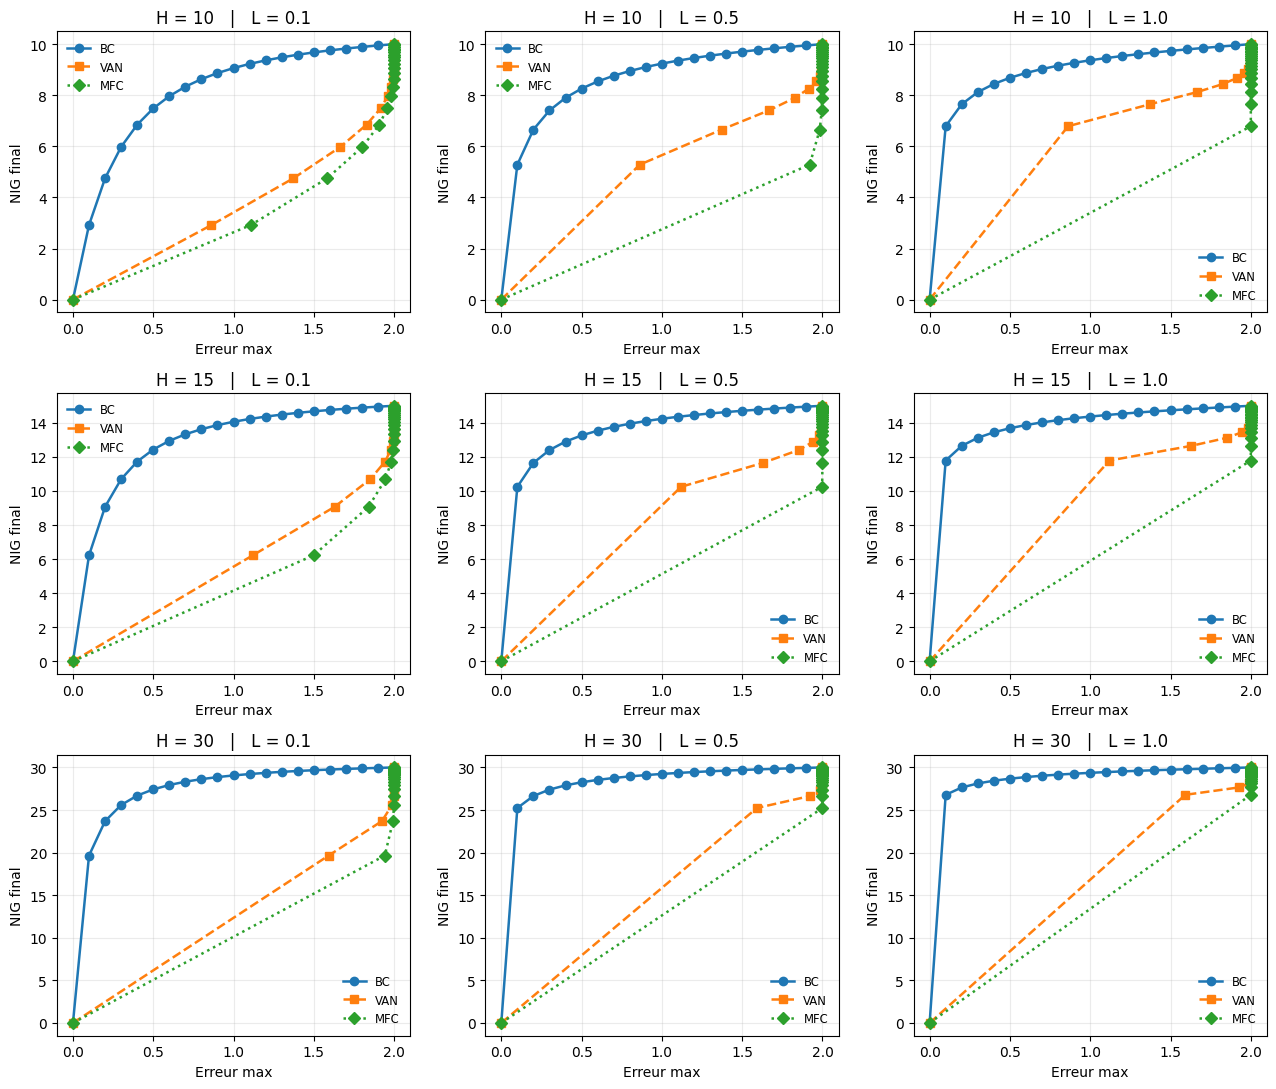

In [ ]:
alpha_grid = np.linspace(0, 1, 21)           
H_list     = [10, 15, 30]
L_list     = [0.1, 0.5, 1.0]

series      = ("BC", "VAN", "MFC")
colors      = dict(zip(series, ("tab:blue", "tab:orange", "tab:green")))
linestyles  = dict(zip(series, ("-", "--", ":")))
markers     = dict(zip(series, ("o", "s", "D")))

fig, axes = plt.subplots(
    nrows=3, ncols=3,
    figsize=(13, 11),
    sharex=False, sharey=False,
)

plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": .25,
    "lines.linewidth": 1.8,
    "font.size": 10,
})


for (i, H), (j, L) in itertools.product(enumerate(H_list), enumerate(L_list)):
    ax = axes[i, j]

    results = {s: {"err_max": [], "nig_final": []} for s in series}
    game = AttractorMFG(H, L) # init du MFG

    for alpha in alpha_grid:

        nig_k = game.NIG(alpha)
        nig_final = float(nig_k[-1])
        
        # calcul des erreurs
        bc, van, mfc = game.errors(alpha)
        errs = dict(BC=max(bc), VAN=max(van), MFC=max(mfc))

        for s in series:
            results[s]["err_max"].append(errs[s])
            results[s]["nig_final"].append(nig_final)

    for s in series:
        ax.plot(
            results[s]["err_max"],
            results[s]["nig_final"],
            color=colors[s],
            linestyle=linestyles[s],
            marker=markers[s],
            label=s,
        )

    ax.set_title(f"H = {H}   |   L = {L}")
    ax.set_xlabel("Erreur max")
    ax.set_ylabel("NIG final")
    ax.legend(frameon=False, fontsize="small")

plt.tight_layout()
plt.show()


---

## Evolution of NIG/Error Ratios Across Congestion Levels

This experiment studies how the ratio between cumulative performance (NIG) and error evolves over time, for different values of the congestion parameter $ L $, in the Attractor MFG setting.

### Setup

- *Horizon*: $ H = 30 $
- *Fixed policy*: $ \alpha = 0.2 $
- *Congestion levels*: 9 values of $ L \in [0.1, 3.0] $
- *Metrics tracked*:
  - Behavior Cloning error (BC)
  - Vanilla Adversarial error (VAN)
  - Model Predictive Control error (MFC)
- *Performance measure*: Nash Imitation Gap (NIG), accumulated over time

### What is plotted

For each value of $ L $, we plot three curves (BC, VAN, MFC) showing the quantity:

$$
\frac{\text{NIG}_k}{\varepsilon_k}
\quad \text{for } k = 0, \dots, H
$$

Each subplot corresponds to one congestion level. The use of a log-log scale highlights both early and late-stage behaviors, and reveals the relative dominance of performance over approximation error throughout learning.

### Purpose

This visualization helps identify regimes where policies manage to extract high global value (via NIG) while keeping local approximation errors under control. It also shows how the difficulty of the learning task scales with the congestion level $ L $.


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_15958/1741756570.py:44: RuntimeWarning: divide by zero encountered in log
  "BC" : np.log(np.log(1 + (nig / (bc  + EPS)))),
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_15958/1741756570.py:45: RuntimeWarning: divide by zero encountered in log
  "VAN": np.log(np.log(1 + (nig / (van + EPS)))),
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_15958/1741756570.py:46: RuntimeWarning: divide by zero encountered in log
  "MFC": np.log(np.log(1 + (nig / (mfc + EPS)))),


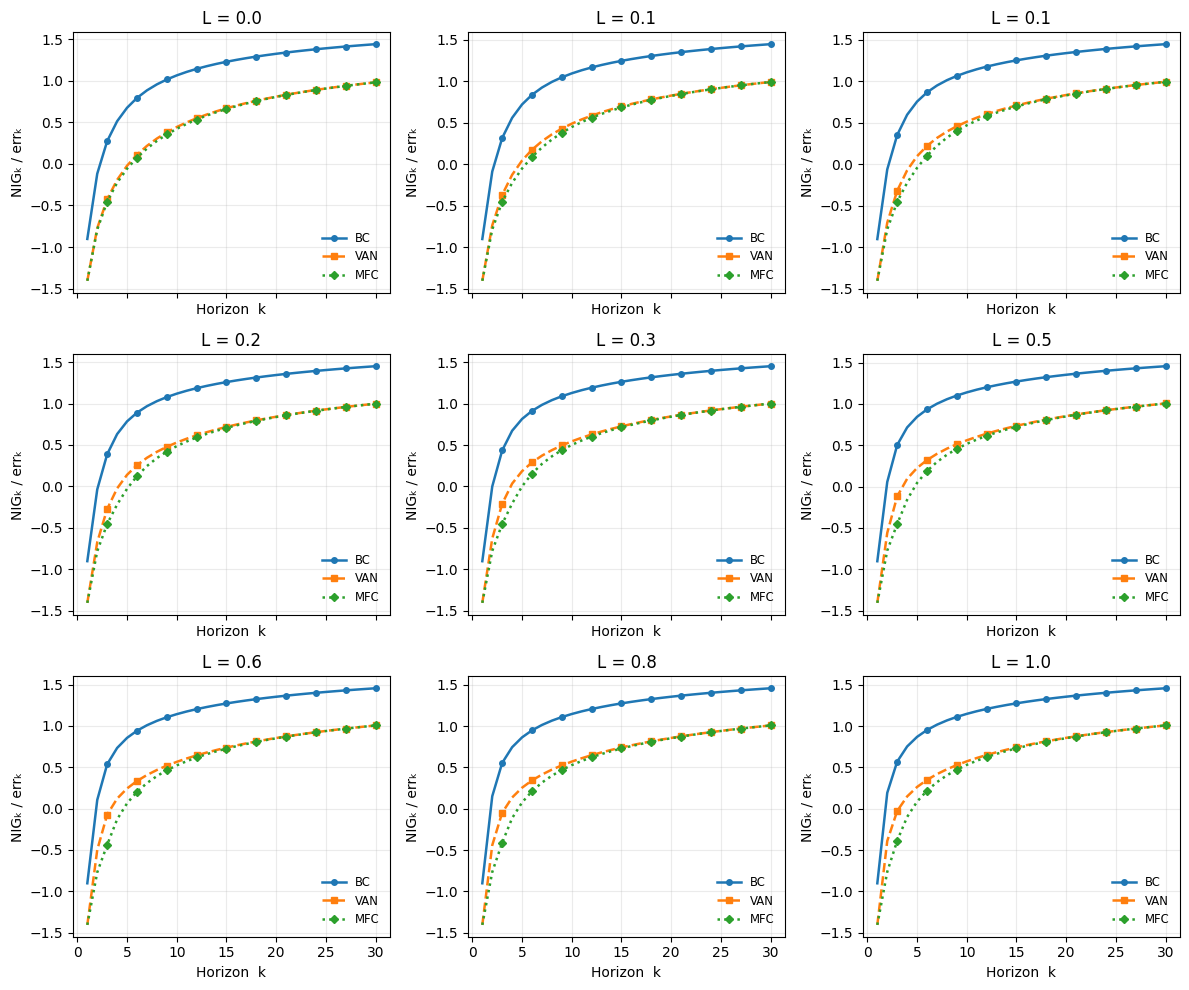

In [ ]:
HORIZON = 30                       
L_LIST  = np.array([0.1, 0.3, 0.5, 0.7, 1.0,
           1.5, 2.0, 2.5, 3.0]) 
alpha = 0.2

series    = ("BC", "VAN", "MFC")
colors    = dict(zip(series, ("tab:blue", "tab:orange", "tab:green")))
linestyle = dict(zip(series, ("-", "--", ":")))
markers    = dict(zip(series, ("o", "s", "D")))

EPS = 1e-12

fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(12, 10),
    sharex=True,                      
    sharey=False,
)

plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": .25,
    "font.size": 10,
    "lines.linewidth": 1.8,
})

for ax, l in zip(axes.flat, L_LIST):
    
    game = AttractorMFG(HORIZON, l)
    bc, van, mfc = map(np.asarray, game.errors(alpha))    
    nig          = np.asarray(game.NIG(alpha))         

    ratio = {
        "BC" : np.log(np.log(1 + (nig / (bc  + EPS)))),
        "VAN": np.log(np.log(1 + (nig / (van + EPS)))),
        "MFC": np.log(np.log(1 + (nig / (mfc + EPS)))),
    }
    k = np.arange(len(nig))                         

    for s in series:
        ax.plot(
            k,
            ratio[s],
            label=s,
            color=colors[s],
            linestyle=linestyle[s],
            marker=markers[s],
            markevery=max(len(k)//10, 1),           
            ms=4,
        )

    ax.set_title(f"L = {int(10 * l /3) / 10}")
    ax.set_xlabel("Horizon  k")
    ax.set_ylabel("NIGₖ / errₖ")
    ax.legend(frameon=False, fontsize="small")

plt.tight_layout()
plt.show()


---

## **Another Toy Example: Crowd Avoidance MFG**

This toy model describes a Mean Field Game with 2 states $\mathcal{S} = \{s_0, s_1\}$, where each agent chooses at each time step between two actions: staying in the safe state $s_0$ or migrating to the congested state $s_1$. The dynamics depend on the level of crowding: the more agents are in $s_1$, the harder it becomes to enter it, and the higher the cost.

#### Dynamics

* Agents in $s_1$ remain there permanently.

* Agents in $s_0$ who choose the `go` action reach $s_1$ with a success probability:

  $$
  P(s_1 | s_0, \text{go}, \rho_t) = \max(0, 1 - L \cdot \rho_t(s_1)^2)
  $$

* The proportion $\rho_t(s_1)$ of agents in $s_1$ is updated via:

  $$
  \rho_{t+1}^{\pi} = \rho_t^{\pi} + (1 - \rho_t^{\pi}) \cdot \alpha \cdot (1 - L (\rho_t^{\pi})^2)_+
  $$

  and similarly for $\rho_t^{E\pi}$ with $\alpha = 1$.

#### Policy

The policy is parameterized by $\alpha \in [0,1]$, which represents the probability that an agent in $s_0$ chooses `go`. We denote:

* $\pi_\alpha$ the actual policy  
* $E\pi$ the "extreme" policy that always chooses `go`

#### Quantities computed

* Behavior Cloning error (BC):

  $$
  \varepsilon_t^\text{BC} = 2\alpha
  $$

* Vanilla-ADV error:

  $$
  \varepsilon_t^\text{vanilla} = 2 \cdot \left( \alpha + \rho_t^{E\pi}(1 - \alpha) \right)
  $$

* MPC-ADV error:

  $$
  \varepsilon_t^\text{MPC} = 2 \cdot \left( \alpha + \rho_t^{\pi}(1 - \alpha) \right)
  $$

* Nash Imitation Gap (NIG), amount of agents who reached state $s_1$:

  $$
  \mathcal{E}(\pi) = \sum_{t=0}^{H-1} \rho_t^{\pi}
  $$

#### Objective

This model is designed to explore the effect of overcrowding on collective dynamics. It compares different imitation errors (BC, ADV) depending on the parameter $L$ (congestion strength), the horizon $H$, and the policy $\alpha$, in order to analyze how they influence performance (measured by NIG).

---

### *Comparison: Attractor MFG vs Crowd Avoidance MFG*

#### **Common Features**

- Two-state Mean Field Games: $\mathcal{S} = \{s_0, s_1\}$
- Absorbing state $s_1$: agents remain there once entered
- Policy parametrized by $\alpha \in [0, 1]$: probability to take action `go` from $s_0$
- Cost incurred only in $s_1$ (constant cost = 2)
- Same analytical expressions for:
  - Behavior Cloning error (BC)
  - Vanilla adversarial error (vanilla-ADV)
  - MPC-based adversarial error (MPC-ADV)
  - Nash Imitation Gap (NIG)

#### **Key Differences**

| Aspect                | Attractor MFG                                      | Crowd Avoidance MFG                                 |
|-----------------------|----------------------------------------------------|-----------------------------------------------------|
| Transition to $s_1$   | Always successful with action `go`                | Success probability decreases with crowding         |
| Congestion effect     | Positive feedback: crowd attracts more agents     | Negative feedback: crowd repels new entries         |
| Transition law        | Deterministic once action is chosen               | Stochastic due to $\rho_t(s_1)$-dependent success   |
| Dynamics under $\pi$  | Amplifying dynamics                               | Saturating and self-limiting dynamics               |
| Goal of analysis      | Study irreversible attraction                     | Study congestion and collective inhibition          |

Despite using the same error formulas, the two models offer distinct learning challenges due to their opposite feedback mechanisms.


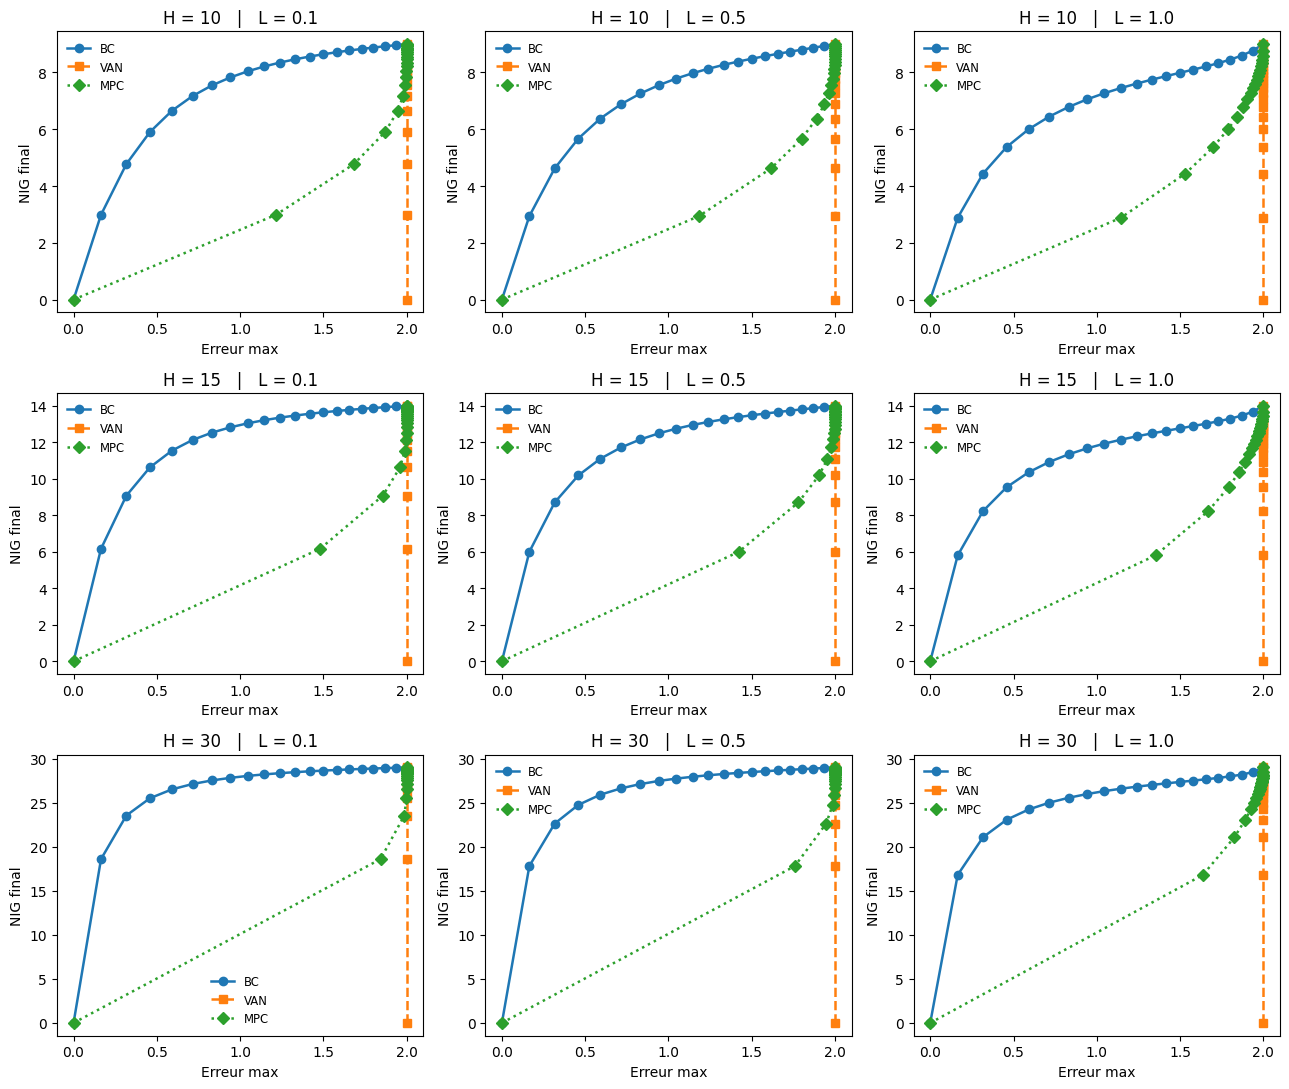

In [3]:
alpha_grid = np.log(np.linspace(1, np.exp(1), 21))   

H_list     = [10, 15, 30]
L_list     = np.array([0.1, 0.5, 1.0]) 

series      = ("BC", "VAN", "MPC")           # <-- nouveau nom
colors      = dict(zip(series, ("tab:blue", "tab:orange", "tab:green")))
linestyles  = dict(zip(series, ("-", "--", ":")))
markers     = dict(zip(series, ("o", "s", "D")))

fig, axes = plt.subplots(
    nrows=3, ncols=3,
    figsize=(13, 11),
    sharex=False, sharey=False,
)

plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": .25,
    "lines.linewidth": 1.8,
    "font.size": 10,
})

for (i, H), (j, L) in itertools.product(enumerate(H_list), enumerate(L_list)):
    ax = axes[i, j]

    results = {s: {"err_max": [], "nig_final": []} for s in series}

    game = CrowdAvoidanceMFG(H, L)          

    for alpha in alpha_grid:

        nig_final = game.NIG(alpha)

        bc, van, mpc = game.errors(alpha)
        
        errs = dict(BC=max(bc), VAN= max(van), MPC=max(mpc))

        for s in series:
            results[s]["err_max"].append(errs[s])
            results[s]["nig_final"].append(nig_final)

    for s in series:
        ax.plot(
            results[s]["err_max"],
            results[s]["nig_final"],
            color=colors[s],
            linestyle=linestyles[s],
            marker=markers[s],
            label=s,
        )

    ax.set_title(f"H = {H}   |   L = {L}")
    ax.set_xlabel("Erreur max")
    ax.set_ylabel("NIG final")
    ax.legend(frameon=False, fontsize="small")

plt.tight_layout()
plt.show()


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_15958/2084896680.py:43: RuntimeWarning: divide by zero encountered in log
  "BC" : np.log(np.log(1 + (nig_k / (bc  + EPS)))),
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_15958/2084896680.py:44: RuntimeWarning: divide by zero encountered in log
  "VAN": np.log(np.log(1 + (nig_k / (van + EPS)))),
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_15958/2084896680.py:45: RuntimeWarning: divide by zero encountered in log
  "MPC": np.log(np.log(1 + (nig_k / (mpc + EPS)))),


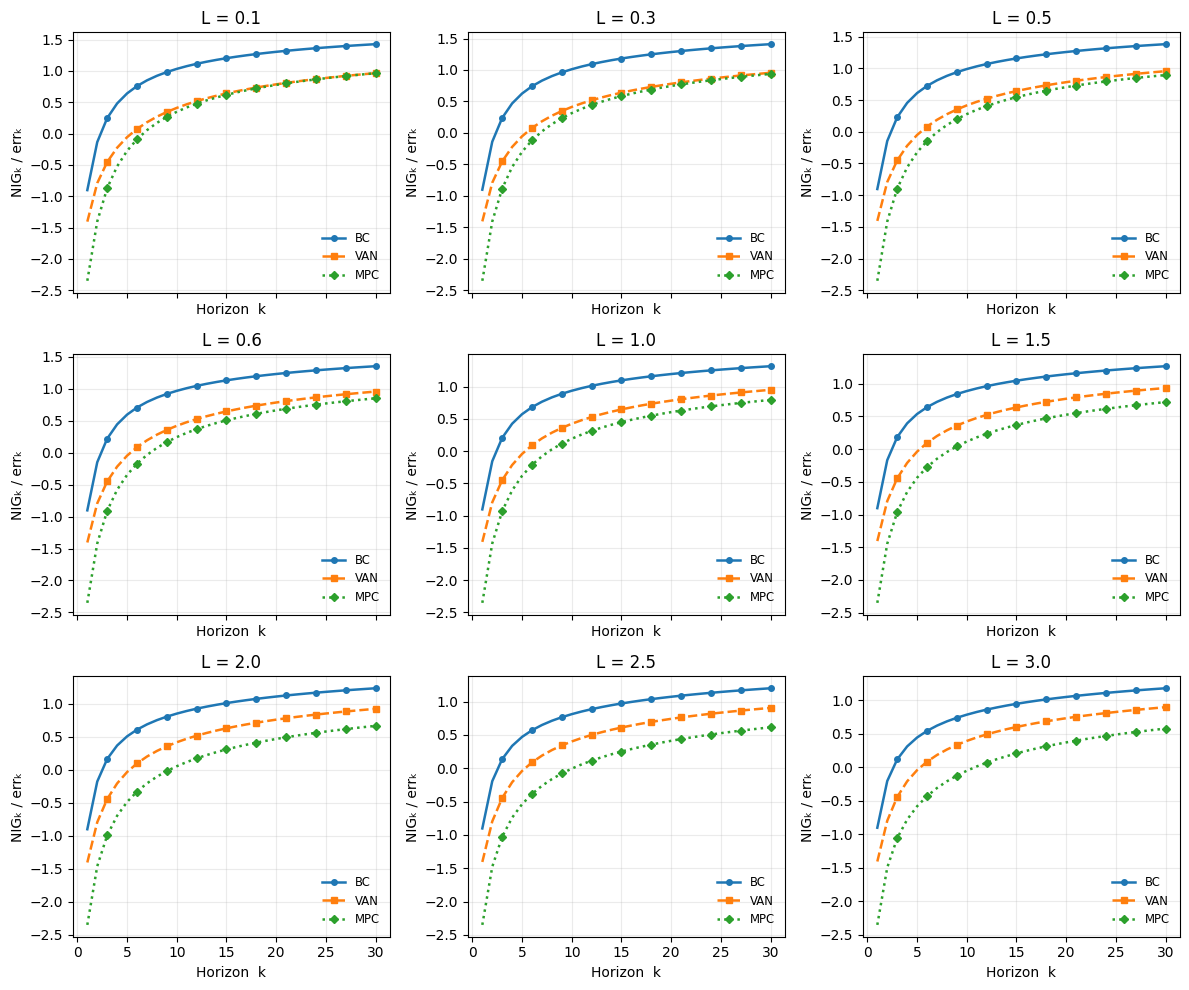

In [ ]:
HORIZON = 30
L_LIST  = np.array([0.1, 0.3, 0.5, 0.7, 1.0,
                    1.5, 2.0, 2.5, 3.0]) * 3  
alpha   = 0.2

series     = ("BC", "VAN", "MPC")             
colors     = dict(zip(series, ("tab:blue", "tab:orange", "tab:green")))
linestyle  = dict(zip(series, ("-", "--", ":")))
markers    = dict(zip(series, ("o", "s", "D")))

EPS = 1e-12                                   

fig, axes = plt.subplots(
    nrows=3, ncols=3,
    figsize=(12, 10),
    sharex=True, sharey=False,
)

plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": .25,
    "font.size": 10,
    "lines.linewidth": 1.8,
})

for ax, l in zip(axes.flat, L_LIST):
    
    game = CrowdAvoidanceMFG(HORIZON, l)  
    bc, mpc, van = map(np.asarray, game.errors(alpha))
    
    game.run(alpha)
    nig_k = np.cumsum(np.asarray(game.hist_pa))   

    ratio = {
        "BC" : np.log(np.log(1 + (nig_k / (bc  + EPS)))),
        "VAN": np.log(np.log(1 + (nig_k / (van + EPS)))),
        "MPC": np.log(np.log(1 + (nig_k / (mpc + EPS)))),
    }
    k = np.arange(len(nig_k))                    

    for s in series:
        ax.plot(
            k,
            ratio[s],
            label=s,
            color=colors[s],
            linestyle=linestyle[s],
            marker=markers[s],
            markevery=max(len(k) // 10, 1),
            ms=4,
        )

    ax.set_title(f"L = {int(10 * l / 3) / 10}")
    ax.set_xlabel("Horizon  k")
    ax.set_ylabel("NIGₖ / errₖ")
    ax.legend(frameon=False, fontsize="small")

plt.tight_layout()
plt.show()


---

### **Tri-State Congestion MFG — Structure and Dynamics**

This mean field game (MFG) model features agents moving across three distinct states: a neutral state $s_0$, a congested but attractive state $s_1$, and a desirable state $s_2$, which is harder to reach. Agents choose between three actions from $s_0$, and the transition probabilities depend on the current proportion of agents in each state, modeling effects of congestion and indirect imitation.

---

#### Game structure

* States: $\mathcal{S} = \{s_0, s_1, s_2\}$
* Possible actions from $s_0$:

  * stay: remain in $s_0$
  * to\_s1: attempt to migrate to $s_1$
  * to\_s2: attempt to migrate to $s_2$
* Parametrized policy:

$$
\pi_\alpha(s_0) = (\text{stay}: 1 - \alpha_1 - \alpha_2,\; \text{to}_s1: \alpha_1,\; \text{to}_s2: \alpha_2)
$$

with $\alpha_1, \alpha_2 \in [0,1]$ and $\alpha_1 + \alpha_2 \leq 1$.

---

#### Temporal dynamics

At each time $t$, let $\rho_t(s)$ be the proportion of agents in state $s$. We initialize:

$$
\rho_0(s_0) = 1,\quad \rho_0(s_1) = \rho_0(s_2) = 0
$$

Then at each time step:

* Agents in $s_1$ or $s_2$ remain where they are.
* Agents in $s_0$ migrate according to:

  * To $s_1$: success with probability $1 - L_1 \cdot \rho_t(s_1)$
  * To $s_2$: success with probability $\rho_t(s_1) \cdot (1 - L_2 \cdot \rho_t(s_2))$

We denote:

$$
\begin{aligned}
p_1 &= \alpha_1 \cdot (1 - L_1 \cdot \rho_t(s_1)) \\
p_2 &= \alpha_2 \cdot \rho_t(s_1) \cdot (1 - L_2 \cdot \rho_t(s_2)) \\
\end{aligned}
$$

And the proportion update follows:

$$
\begin{aligned}
\rho_{t+1}(s_0) &= \rho_t(s_0) \cdot (1 - p_1 - p_2) \\
\rho_{t+1}(s_1) &= \rho_t(s_1) + \rho_t(s_0) \cdot p_1 \\
\rho_{t+1}(s_2) &= \rho_t(s_2) + \rho_t(s_0) \cdot p_2 \\
\end{aligned}
$$

---

#### Quantities measured

* Behavior Cloning error (BC): constant

$$
\varepsilon_t^\text{BC} = 2(\alpha_1 + \alpha_2)
$$

* Vanilla-ADV error (based on an extreme policy that always migrates):

$$
\varepsilon_t^\text{vanilla} = 2\left( \alpha_1 + \alpha_2 + (1 - \alpha_1 - \alpha_2)\cdot (\rho_t^{E\pi}(s_1) + \rho_t^{E\pi}(s_2)) \right)
$$

* MPC-ADV error (under policy $\pi_\alpha$):

$$
\varepsilon_t^\text{MPC} = 2\left( \alpha_1 + \alpha_2 + (1 - \alpha_1 - \alpha_2)\cdot (\rho_t^{\pi}(s_1) + \rho_t^{\pi}(s_2)) \right)
$$

* Nash Imitation Gap:

$$
\mathcal{E}(\pi) = \sum_{t=0}^{H-1} \left( \rho_t^{\pi}(s_1) + \rho_t^{\pi}(s_2) \right)
$$

---

#### Model relevance

This model highlights rich interaction effects:

* direct congestion ($L_1, L_2$)
* selective bottleneck: reaching $s_2$ requires that $s_1$ is already sufficiently populated
* indirect dynamics: state $s_1$ acts as a gateway to $s_2$
* cascading behavior: with some policies, the agent population shifts abruptly

The model remains fully analytical and easily simulable, making it well-suited for studying learning or robustness in MFG settings.


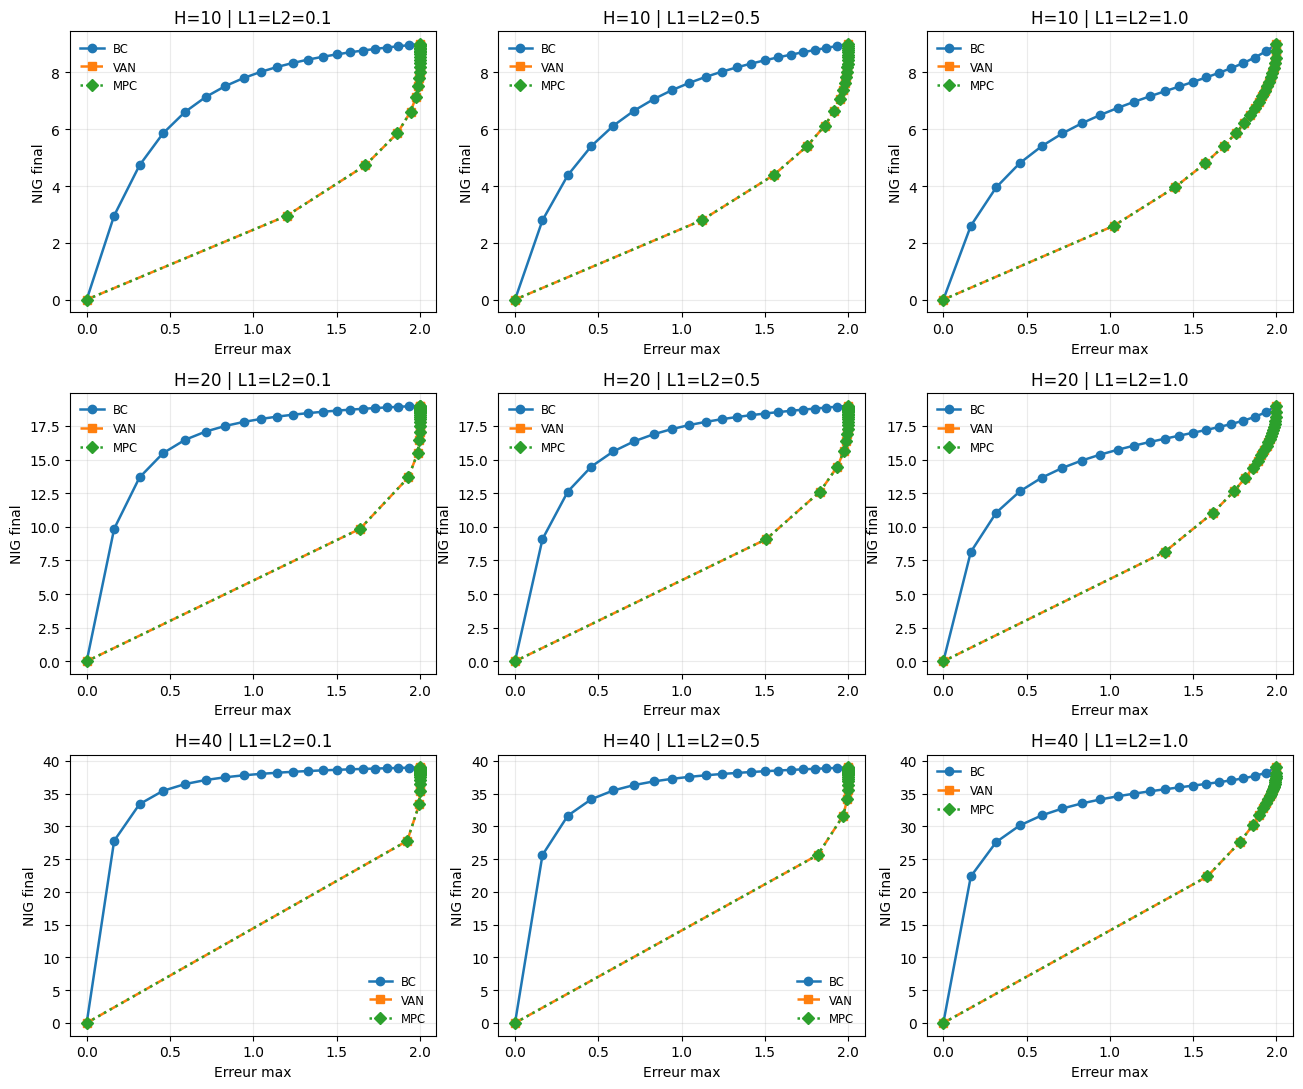

In [4]:
alpha1_grid = np.log(np.linspace(1, np.exp(1), 21))        
alpha2_fixed = 0.0                         

H_list  = [10, 20, 40]
L_list  = [0.1, 0.5, 1.0]                    

series      = ("BC", "VAN", "MPC")
colors      = dict(zip(series, ("tab:blue", "tab:orange", "tab:green")))
linestyles  = dict(zip(series, ("-", "--", ":")))
markers     = dict(zip(series, ("o", "s", "D")))

fig, axes = plt.subplots(3, 3, figsize=(13, 11))

plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": .25,
    "lines.linewidth": 1.8,
    "font.size": 10,
})

for (i, H), (j, L) in itertools.product(enumerate(H_list), enumerate(L_list)):
    ax = axes[i, j]
    results = {s: {"err_max": [], "nig_final": []} for s in series}

    game = TriStateCongestionMFG(H, L1=L, L2=L)

    for a1 in alpha1_grid:
        nig_final = game.NIG(a1, alpha2_fixed)

        bc, van, mpc = game.errors(a1, alpha2_fixed)
        errs = dict(BC=np.max(bc), VAN=np.max(van), MPC=np.max(mpc))

        for s in series:
            results[s]["err_max"].append(errs[s])
            results[s]["nig_final"].append(nig_final)

    for s in series:
        ax.plot(results[s]["err_max"],
                results[s]["nig_final"],
                color=colors[s], linestyle=linestyles[s],
                marker=markers[s], label=s)

    ax.set_title(f"H={H} | L1=L2={L}")
    ax.set_xlabel("Erreur max")
    ax.set_ylabel("NIG final")
    ax.legend(frameon=False, fontsize="small")

plt.tight_layout()
plt.show()


/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_15958/735681091.py:45: RuntimeWarning: divide by zero encountered in log
  "BC" : np.log(np.log(1 + (nig_k / (bc  + EPS)))),
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_15958/735681091.py:46: RuntimeWarning: divide by zero encountered in log
  "VAN": np.log(np.log(1 + (nig_k / (van + EPS)))),
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_15958/735681091.py:47: RuntimeWarning: divide by zero encountered in log
  "MPC": np.log(np.log(1 + (nig_k / (mpc + EPS)))),


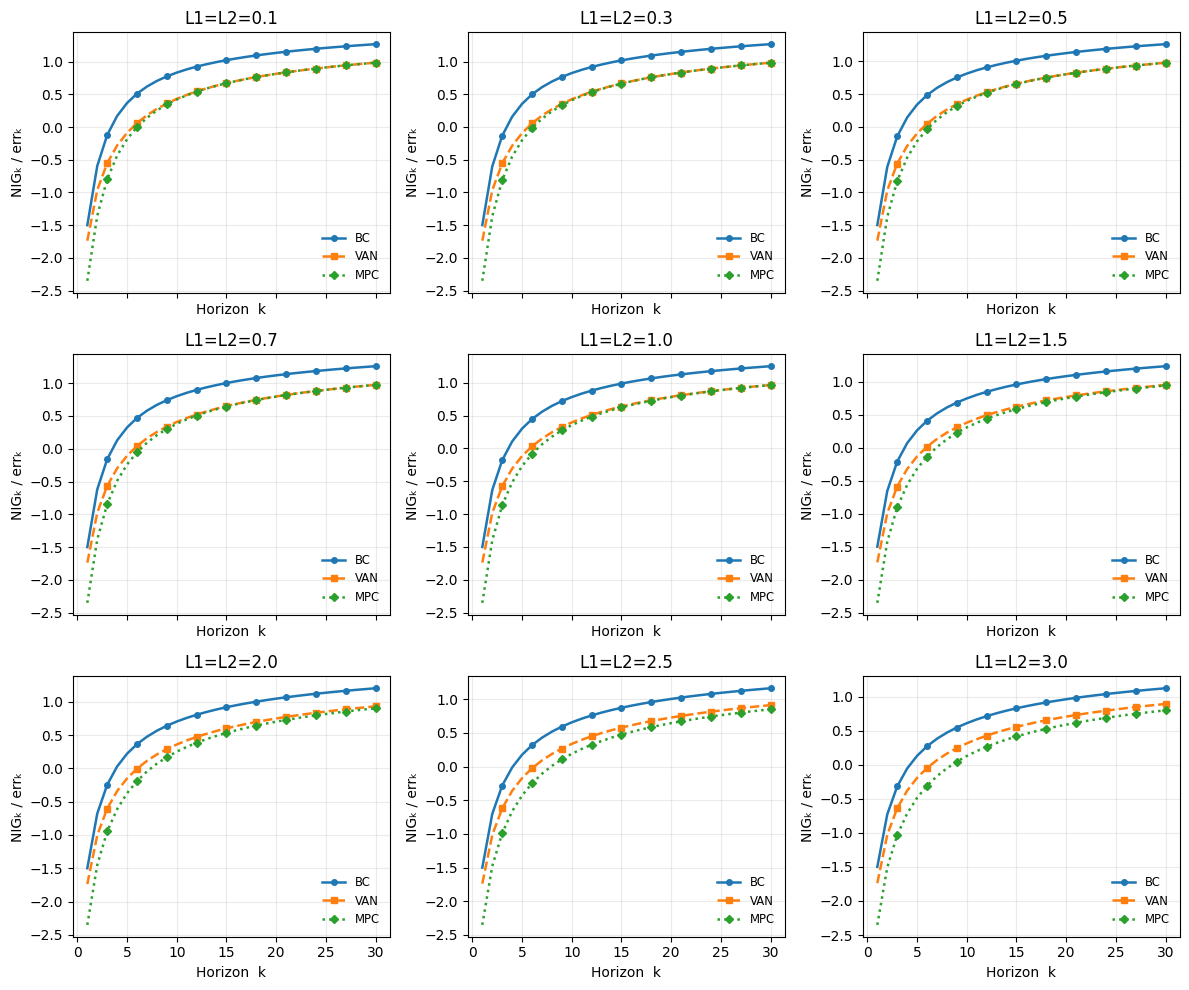

In [ ]:
HORIZON = 30
L_PAIRS = [(x, x) for x in
           [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0]] 
alpha1 = alpha2 = 0.2

series     = ("BC", "VAN", "MPC")
colors     = dict(zip(series, ("tab:blue", "tab:orange", "tab:green")))
linestyle  = dict(zip(series, ("-", "--", ":")))
markers    = dict(zip(series, ("o", "s", "D")))
EPS = 1e-12

fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=True)

plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": .25,
    "lines.linewidth": 1.8,
    "font.size": 10,
})

for ax, (L1, L2) in zip(axes.flat, L_PAIRS):
    
    game = TriStateCongestionMFG(HORIZON, L1=L1, L2=L2)
    bc, mpc, van = map(np.asarray, game.errors(alpha1, alpha2))

    game.run(alpha1, alpha2)
    hist_pi = np.asarray(game.hist_pi)                    
    crowd   = hist_pi[:, 1] + hist_pi[:, 2]                
    nig_k   = np.cumsum(crowd)                             

    ratios = {
        "BC" : np.log(np.log(1 + (nig_k / (bc  + EPS)))),
        "VAN": np.log(np.log(1 + (nig_k / (van + EPS)))),
        "MPC": np.log(np.log(1 + (nig_k / (mpc + EPS)))),
    }
    k = np.arange(len(nig_k))                              

    for s in series:
        ax.plot(k, ratios[s],
                label=s, color=colors[s],
                linestyle=linestyle[s], marker=markers[s],
                markevery=max(len(k)//10, 1), ms=4)

    ax.set_title(f"L1=L2={L1}")
    ax.set_xlabel("Horizon  k")
    ax.set_ylabel("NIGₖ / errₖ")
    ax.legend(frameon=False, fontsize="small")

plt.tight_layout()
plt.show()


---

Garbage

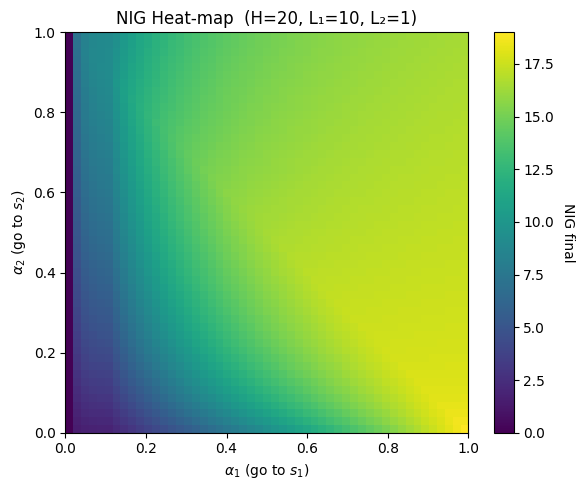

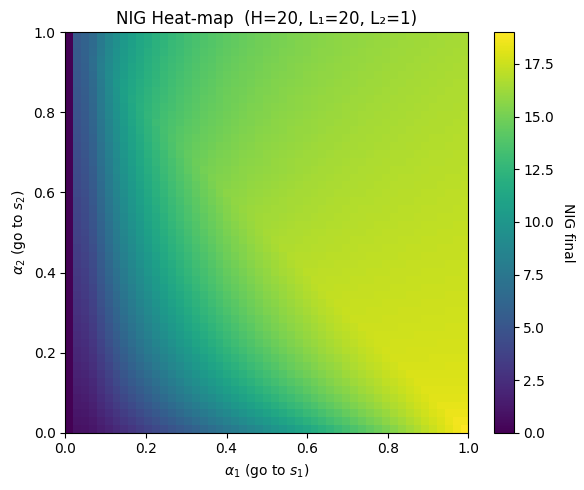

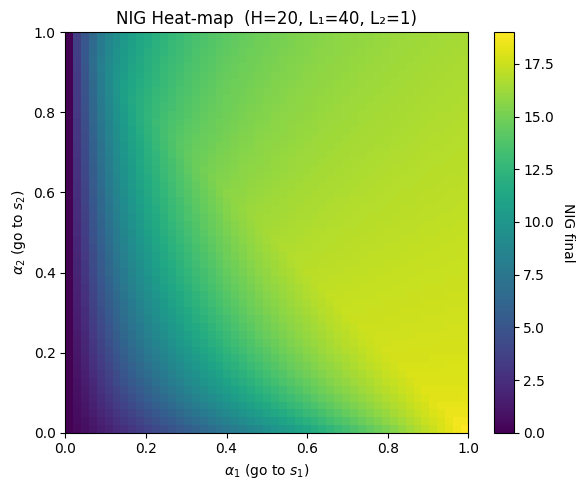

In [8]:
Ls = [10, 20, 40]  # Longueurs de l’horizon
for l in Ls: 
    plot_nig_heatmap(H=20, L1=l, L2=1, n_pts=51)


### **More Analytics**

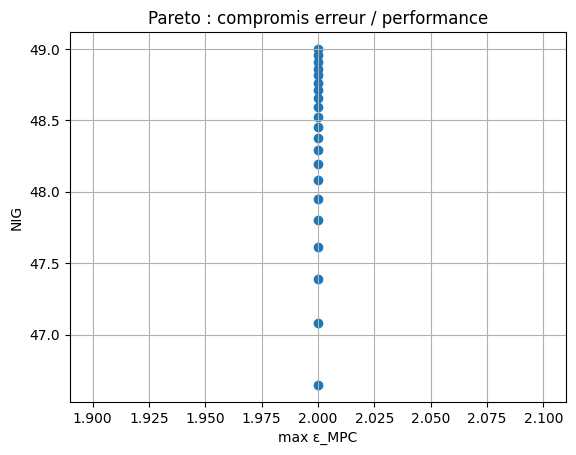

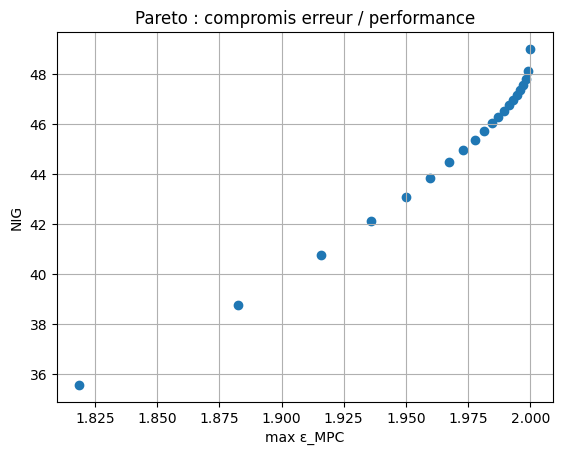

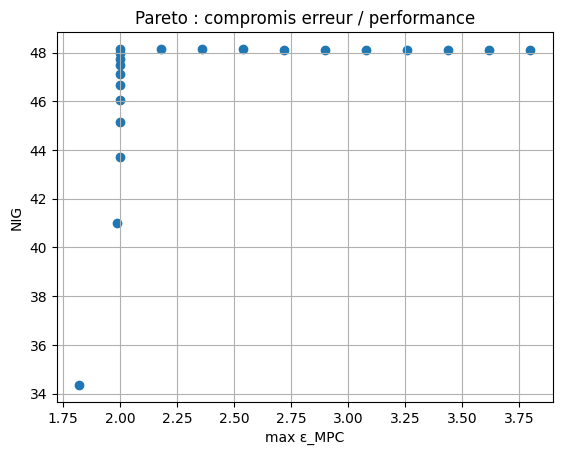

In [2]:
alpha_grid = np.linspace(0.1, 1, 21) 
alpha_tuple_grid = [(a, a-0.1) for a in alpha_grid]

plot_pareto_eps_vs_nig(AttractorMFG,
                       param_grid=alpha_grid,
                       horizon=50,
                       extra_kwargs={"L": 1.0})

plot_pareto_eps_vs_nig(CrowdAvoidanceMFG,
                       param_grid=alpha_grid,
                       horizon=50,
                       extra_kwargs={"L": 1.0})

plot_pareto_eps_vs_nig(TriStateCongestionMFG,
                       param_grid=alpha_tuple_grid,
                       horizon=50,
                       extra_kwargs={"L1": 0.8, "L2": 1.2})

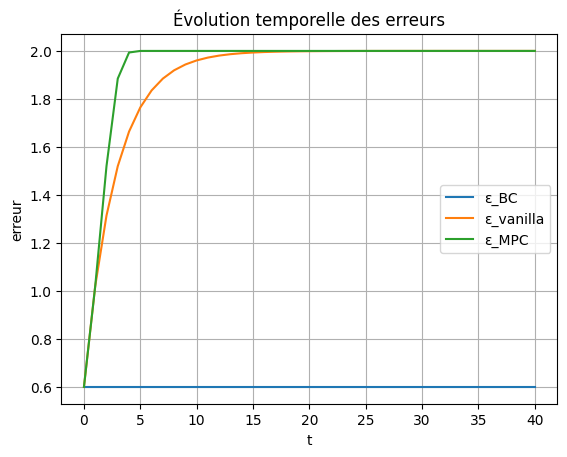

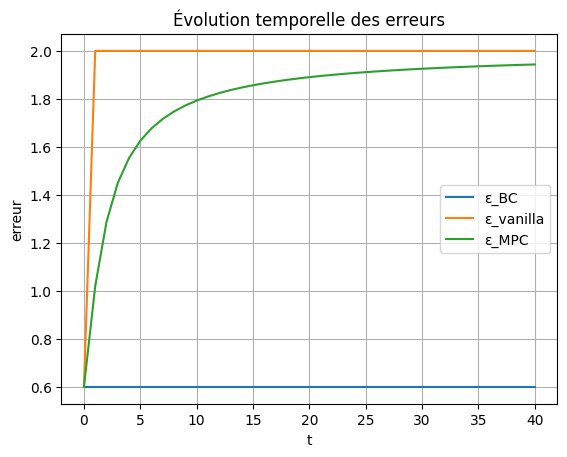

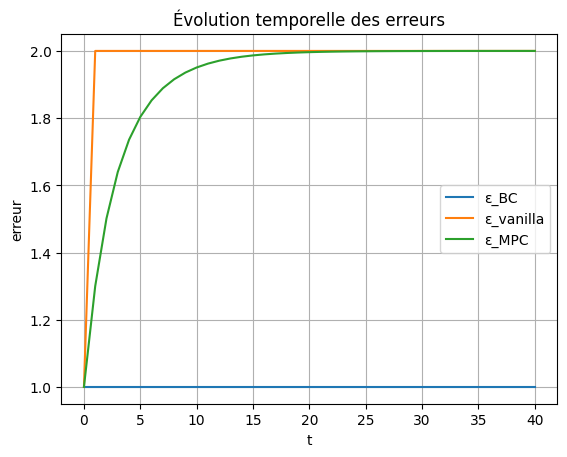

In [35]:
plot_error_curves(AttractorMFG,
                  alphas=0.3,     # α1, α2
                  horizon=40,
                  extra_kwargs={"L": 1.0})

plot_error_curves(CrowdAvoidanceMFG,
                  alphas=0.3,     # α1, α2
                  horizon=40,
                  extra_kwargs={"L": 1.0})

plot_error_curves(TriStateCongestionMFG,
                  alphas=(0.3, 0.2),     # α1, α2
                  horizon=40,
                  extra_kwargs={"L1": 0.8, "L2": 1.2})